In [0]:
#Code snippet to connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#Loading all the necessary libraries for the project
import os
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
from tqdm import tqdm
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.datasets import mnist,cifar10
from sklearn.model_selection import train_test_split
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.applications.vgg16 import VGG16
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform,he_uniform
from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K
from keras.utils import plot_model,normalize
from sklearn.metrics import roc_curve,roc_auc_score

Using TensorFlow backend.


In [0]:
def DrawPics(tensor,nb=0,template='{}',classnumber=None):
  """
  Draw Pics from Tensors
  PARAMETERS
  tensor:
  nb:
  template:
  classnumber
  RETURN
  None  
  """
  if (nb==0):
        N = tensor.shape[0]
  else:
        N = min(nb,tensor.shape[0])
  fig=plt.figure(figsize=(16,2))
  nbligne = floor(N/20)+1
  for m in range(N):
    subplot = fig.add_subplot(nbligne,min(N,20),m+1)
    axis("off")
    plt.imshow(tensor[m,:,:,],vmin=0, vmax=1)
    if (classnumber!=None):
      subplot.title.set_text((template.format(classnumber)))

In [0]:
#Initializing the dataset settings
nb_classes = 4
img_rows, img_cols = 128, 128
input_shape = (img_rows, img_cols, 3)
dataset_train = []
dataset_test = []

def buildDataSet():
    """Build dataset for train and test
    Parameters:
    None
    
    returns:
        dataset : list of lengh 10 containing images for each classes of shape (?,28,28,1)
    """
    #Loading the datasets and labels files
    dataset=np.load('/content/drive/My Drive/Video_Dataset/data128.npy')
    labels=np.load('/content/drive/My Drive/Video_Dataset/labels128.npy')
    labels=labels.reshape(labels.shape[0],1)

    x_train_origin, x_test_origin,y_train_origin, y_test_origin = train_test_split(dataset, labels, test_size=0.33, random_state=42)

    #assert K.image_data_format() == 'channels_last'
    #x_train_origin = x_train_origin.reshape(x_train_origin.shape[0], img_rows, img_cols, 3)
    #x_test_origin = x_test_origin.reshape(x_test_origin.shape[0], img_rows, img_cols, 3)

    
    #Sorting images by classes and normalize values 0=>1
    for n in range(nb_classes):
        temp_train=[]
        temp_test=[]
        for idx,row in enumerate(x_train_origin):
          if y_train_origin[idx,:]==n:
            temp_train.append(row/255)
        temp_train=np.asarray(temp_train)
        dataset_train.append(temp_train)
        for idx,row in enumerate(x_test_origin):
          if y_test_origin[idx,:]==n:
            temp_test.append(row/255)
        dataset_test.append(np.asarray(temp_test))
    
    return dataset_train,dataset_test,x_train_origin,y_train_origin,x_test_origin,y_test_origin

Checking shapes for class 0 (train) :  (222, 128, 128, 3)
Checking shapes for class 0 (test) :  (98, 128, 128, 3)
Checking first samples


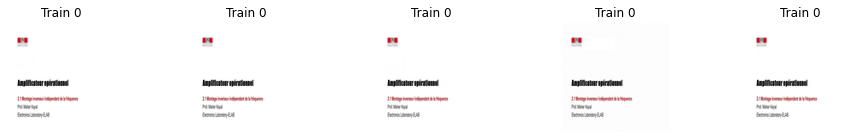

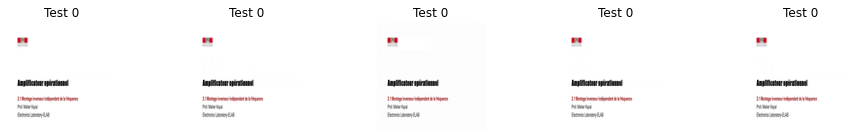

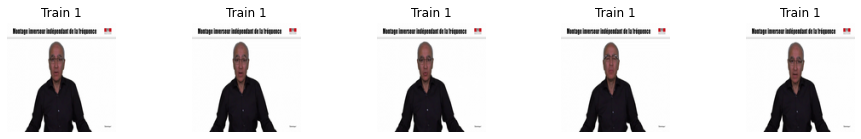

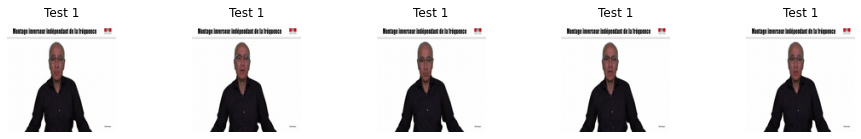

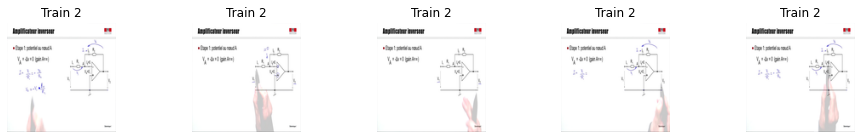

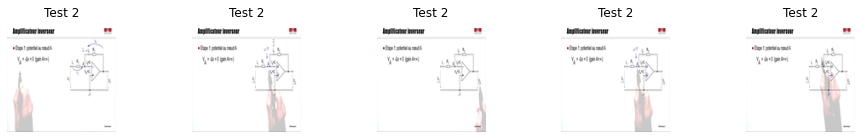

In [0]:
dataset_train,dataset_test,x_train_origin,y_train_origin,x_test_origin,y_test_origin = buildDataSet()
print("Checking shapes for class 0 (train) : ",dataset_train[1].shape)
print("Checking shapes for class 0 (test) : ",dataset_test[1].shape)
print("Checking first samples")
for i in range(3):
    DrawPics(dataset_train[i],5,template='Train {}',classnumber=i)
    DrawPics(dataset_test[i],5,template='Test {}',classnumber=i)

#Implementing Triplet Loss
## L=max(d(A,P)−d(A,N)+margin,0)

# Now our Full Keras model, with the anchor, the positive and the negative picture as inputs

In [0]:
def build_network(input_shape, embeddingsize):
    """
    Building VGG16 Based Transfer learning model trained on imagenet dataset conntected with some dense layers to extract embedding vector
    Parameters:
    input shape: int contains the input shape so, that the model can be build base on that shape
    embedding size: int contains the embedding size, so that the network return the embedding vector of given size
    Returns:
    new_model: Sequential Model Containing the VGG16 and feature extraction combined with embedding layers
    """
    base_model = VGG16(weights='imagenet', include_top=False, input_shape = input_shape)
    print('Model loaded.')
    print(base_model.output_shape[1:])
    top_model = Sequential()  
    top_model.add(Flatten(input_shape=base_model.output_shape[1:])) 
    top_model.add(Dense(4096, activation='relu',kernel_regularizer=l2(1e-3),kernel_initializer='he_uniform'))
    top_model.add(Dense(embeddingsize, activation=None,kernel_regularizer=l2(1e-3),kernel_initializer='he_uniform'))
    top_model.add(Lambda(lambda x: K.l2_normalize(x,axis=-1)))

    new_model = Sequential()
    for l in base_model.layers:
      new_model.add(l)
    new_model.add(top_model)

    return new_model
  
class TripletLossLayer(Layer):
    """
    The triplet loss function, implemented as a custom Keras layer
    """
    def __init__(self, alpha, **kwargs):
      """
      Constructor function for TripletLossLayer Class
      """
      self.alpha = alpha
      super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        """
        Function Implementing the Triplet Loss
        """
        anchor, positive, negative = inputs
        p_dist = K.sum(K.square(anchor-positive), axis=-1)
        n_dist = K.sum(K.square(anchor-negative), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

def build_model(input_shape, network, margin=0.2):
    '''
    Define the Keras Model for training 
        Parameters : 
            input_shape : shape of input images
            network : Neural network to train outputing embeddings
            margin : minimal distance between Anchor-Positive and Anchor-Negative for the lossfunction (alpha)
    Returns:
      network_train : Neural Network contating encodings of anchor,positive and negative input with triplet loss as output
    '''
     # Define the tensors for the three input images
    anchor_input = Input(input_shape, name="anchor_input")
    positive_input = Input(input_shape, name="positive_input")
    negative_input = Input(input_shape, name="negative_input") 
    
    # Generate the encodings (feature vectors) for the three images
    encoded_a = network(anchor_input)
    encoded_p = network(positive_input)
    encoded_n = network(negative_input)
    
    #TripletLoss Layer
    loss_layer = TripletLossLayer(alpha=margin,name='triplet_loss_layer')([encoded_a,encoded_p,encoded_n])
    
    # Connect the inputs with the outputs
    network_train = Model(inputs=[anchor_input,positive_input,negative_input],outputs=loss_layer)
    
    # return the model
    return network_train

In [0]:
network = build_network(input_shape,embeddingsize=10)
network_train = build_model(input_shape,network)
optimizer = Adam(lr = 0.00006)
network_train.compile(loss=None,optimizer=optimizer)
network_train.summary()
plot_model(network_train,show_shapes=True, show_layer_names=True, to_file='02 model.png')
print(network_train.metrics_names)
n_iteration=0
#network_train.load_weights('mnist-160k_weights.h5')

58892288/58889256 [==============================] - 6s 0us/step
Model loaded.
(4, 4, 512)


/usr/local/lib/python3.6/dist-packages/keras/engine/training_utils.py:819: UserWarning: Output triplet_loss_layer missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to triplet_loss_layer.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 10)           48314186    anchor_input[0][0]               
                                                                 positive_input[0][0]       

#Setting Some Layers to be Trainable

In [0]:
network.layers[2].set_trainable=True
network.layers[5].set_trainable=True
network.layers[9].set_trainable=True
network.layers[13].set_trainable=True
network.layers[17].set_trainable=True

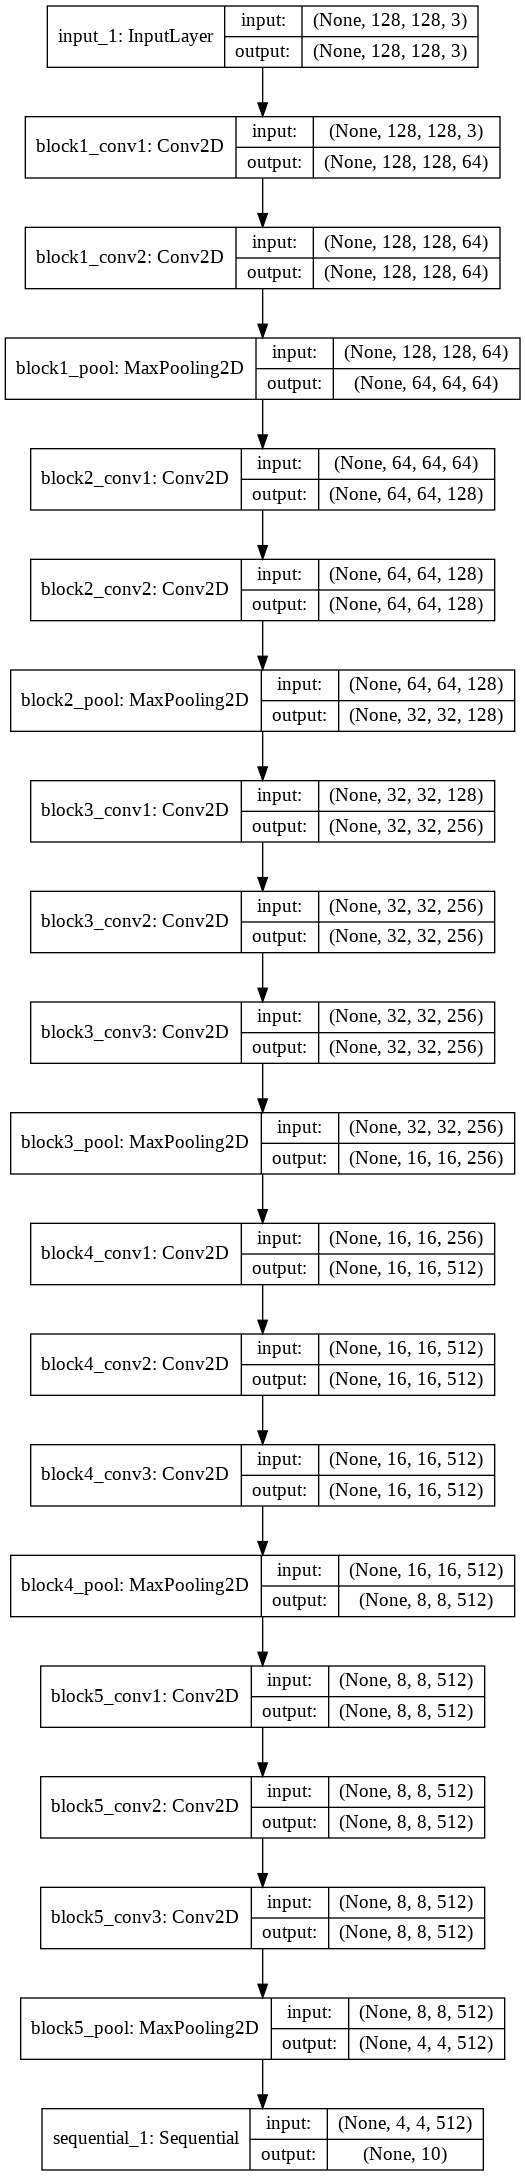

In [0]:
plot_model(network,show_shapes=True, show_layer_names=True, to_file='02 model.png')

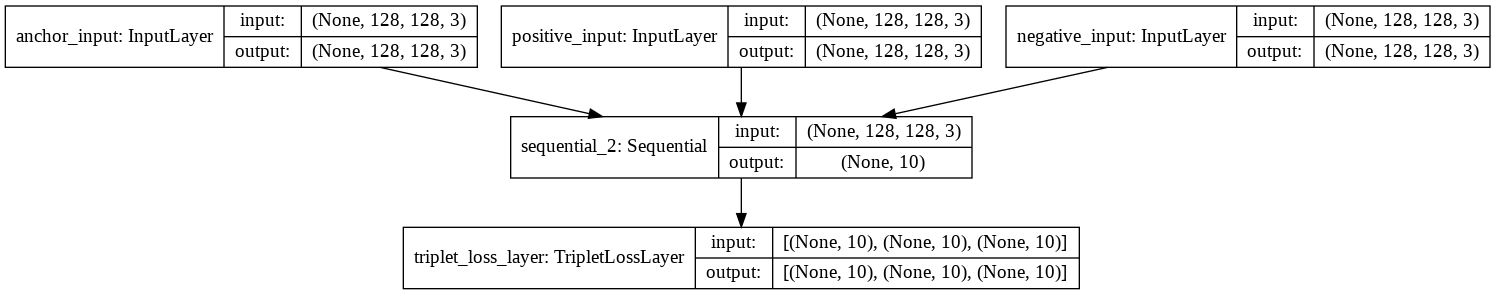

In [0]:
plot_model(network_train,show_shapes=True, show_layer_names=True, to_file='02 model.png')

In [0]:
#testing our NN with dummy image
featured_img = network.predict(np.ones((1,img_rows,img_cols,3)))
print(featured_img)

[[-0.00447918 -0.39381725 -0.06863482  0.31500903  0.46514952  0.23958644
  -0.05919668  0.60557294 -0.02104895  0.31066853]]


In [0]:
dataset_train[0].shape

(59, 128, 128, 3)

In [0]:
def get_batch_random(batch_size,s="train"):
    """
    Create batch of APN triplets with a complete random strategy
    
    Parameters:
    batch_size :int
    Batch Size for training of network

    Returns:
    triplets: list containing 3 tensors A,P,N of shape (batch_size,w,h,c)
    """
    if s == 'train':
        X = dataset_train
    else:
        X = dataset_test
    m, w, h,c = X[1].shape
    # initialize result
    triplets=[np.zeros((batch_size,h, w,c)) for i in range(3)]
    for i in range(batch_size):
        #Pick one random class for anchor
        anchor_class = np.random.randint(0, nb_classes)
        nb_sample_available_for_class_AP = X[anchor_class].shape[0]
        #Pick two different random pics for this class => A and P
        [idx_A,idx_P] = np.random.choice(nb_sample_available_for_class_AP,size=2,replace=False)
        
        #Pick another class for N, different from anchor_class
        negative_class = (anchor_class + np.random.randint(1,nb_classes)) % nb_classes
        nb_sample_available_for_class_N = X[negative_class].shape[0]
        
        #Pick a random pic for this negative class => N
        idx_N = np.random.randint(0, nb_sample_available_for_class_N)

        triplets[0][i,:,:,:] = X[anchor_class][idx_A,:,:,:]
        triplets[1][i,:,:,:] = X[anchor_class][idx_P,:,:,:]
        triplets[2][i,:,:,:] = X[negative_class][idx_N,:,:,:]

    return triplets

def drawTriplets(tripletbatch, nbmax=None):
    """display the three images for each triplets in the batch
    Parameters:
    tripletbatch: list
    Batch of triplets conaining Anchor,Positives and Negative Images
    """
    labels = ["Anchor", "Positive", "Negative"]

    if (nbmax==None):
        nbrows = tripletbatch[0].shape[0]
    else:
        nbrows = min(nbmax,tripletbatch[0].shape[0])
                 
    for row in range(nbrows):
        fig=plt.figure(figsize=(16,2))
    
        for i in range(3):
            subplot = fig.add_subplot(1,3,i+1)
            axis("off")
            plt.imshow(tripletbatch[i][row,:,:,],vmin=0, vmax=1)
            subplot.title.set_text(labels[i])

In [0]:
def compute_dist(a,b):
    """
    Computing the distances between two arrays
    Parameters: 
    a= int
    b= int
    Returns:
    Sum of two arrays
    """
    return np.sum(np.square(a-b))

def get_batch_hard(draw_batch_size,hard_batchs_size,norm_batchs_size,network,s="train"):
    """
    Create batch of APN "hard" triplets
    
    Paramerters:
    draw_batch_size -- integer : number of initial randomly taken samples   
    hard_batchs_size -- interger : select the number of hardest samples to keep
    norm_batchs_size -- interger : number of random samples to add

    Returns:
    triplets -- list containing 3 tensors A,P,N of shape (hard_batchs_size+norm_batchs_size,w,h,c)
    """
    if s == 'train':
        X = dataset_train
    else:
        X = dataset_test

    m, w, h,c = X[0].shape
    
    #Step 1 : pick a random batch to study
    studybatch = get_batch_random(draw_batch_size,s)
    
    #Step 2 : compute the loss with current network : d(A,P)-d(A,N). The alpha parameter here is omited here since we want only to order them
    studybatchloss = np.zeros((draw_batch_size))
    
    #Compute embeddings for anchors, positive and negatives
    A = network.predict(studybatch[0])
    P = network.predict(studybatch[1])
    N = network.predict(studybatch[2])
    
    #Compute d(A,P)-d(A,N)
    studybatchloss = np.sum(np.square(A-P),axis=1) - np.sum(np.square(A-N),axis=1)
    
    #Sort by distance (high distance first) and take the 
    selection = np.argsort(studybatchloss)[::-1][:hard_batchs_size]
    
    #Draw other random samples from the batch
    selection2 = np.random.choice(np.delete(np.arange(draw_batch_size),selection),norm_batchs_size,replace=False)
    
    selection = np.append(selection,selection2)
    
    triplets = [studybatch[0][selection,:,:,:], studybatch[1][selection,:,:,:], studybatch[2][selection,:,:,:]]
    
    return triplets

Checking batch width, should be 3 :  3
Shapes in the batch A:(2, 128, 128, 3) P:(2, 128, 128, 3) N:(2, 128, 128, 3)
Shapes in the hardbatch A:(2, 128, 128, 3) P:(2, 128, 128, 3) N:(2, 128, 128, 3)


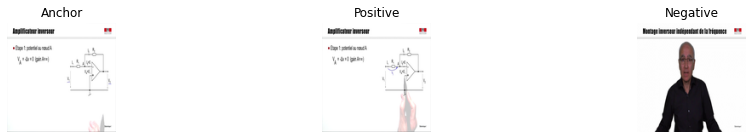

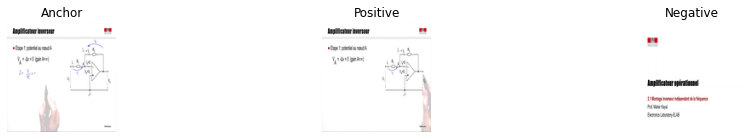

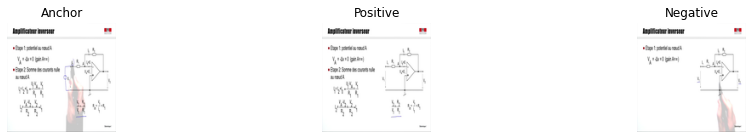

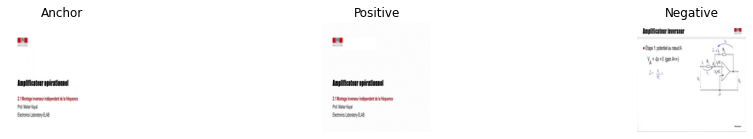

In [0]:
triplets = get_batch_random(2)
print("Checking batch width, should be 3 : ",len(triplets))
print("Shapes in the batch A:{0} P:{1} N:{2}".format(triplets[0].shape, triplets[1].shape, triplets[2].shape))
drawTriplets(triplets)
hardtriplets = get_batch_hard(50,1,1,network)
print("Shapes in the hardbatch A:{0} P:{1} N:{2}".format(hardtriplets[0].shape, hardtriplets[1].shape, hardtriplets[2].shape))
drawTriplets(hardtriplets)

In [0]:
# Hyper parameters used for training of network
evaluate_every = 1000 # interval for evaluating on one-shot tasks
batch_size = 1000
n_iter = 20000 # No. of training iterations
n_val = 250 # how many tasks to validate on

#The evaluation process will take the test dataset and evaluate the distance of all pictures against each other, and then compute the AUC using the sklearn function.

In [0]:
def compute_probs(network,X,Y):
    '''
    Input
        network : current NN to compute embeddings
        X : tensor of shape (m,w,h,1) containing pics to evaluate
        Y : tensor of shape (m,) containing true class
        
    Returns
        probs : array of shape (m,m) containing distances
    
    '''
    m = X.shape[0]
    nbevaluation = int(m*(m-1)/2)
    probs = np.zeros((nbevaluation))
    y = np.zeros((nbevaluation))
    
    #Compute all embeddings for all pics with current network
    embeddings = network.predict(X)
    
    size_embedding = embeddings.shape[1]
    
    #For each pics of our dataset
    k = 0
    for i in range(m):
            #Against all other images
            for j in range(i+1,m):
                #compute the probability of being the right decision : it should be 1 for right class, 0 for all other classes
                probs[k] = -compute_dist(embeddings[i,:],embeddings[j,:])
                if (Y[i]==Y[j]):
                    y[k] = 1
                    #print("{3}:{0} vs {1} : {2}\tSAME".format(i,j,probs[k],k))
                else:
                    y[k] = 0
                    #print("{3}:{0} vs {1} : \t\t\t{2}\tDIFF".format(i,j,probs[k],k))
                k += 1
    return probs,y
#probs,yprobs = compute_probs(network,x_test_origin[:10,:,:,:],y_test_origin[:10])

def compute_metrics(probs,yprobs):
    '''
    Parameters:
    Probs: list containing the probabilitites values predicted
    yprobs: list containing the actual probability values
    Returns:
        fpr : Increasing false positive rates such that element i is the false positive rate of predictions with score >= thresholds[i]
        tpr : Increasing true positive rates such that element i is the true positive rate of predictions with score >= thresholds[i].
        thresholds : Decreasing thresholds on the decision function used to compute fpr and tpr. thresholds[0] represents no instances being predicted and is arbitrarily set to max(y_score) + 1
        auc : Area Under the ROC Curve metric
    '''
    # calculate AUC
    auc = roc_auc_score(yprobs, probs)
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(yprobs, probs)
    
    return fpr, tpr, thresholds,auc

def compute_interdist(network):
    '''
    Computes sum of distances between all classes embeddings on our reference test image: 
        d(0,1) + d(0,2) + ... + d(0,9) + d(1,2) + d(1,3) + ... d(8,9)
        A good model should have a large distance between all theses embeddings
        
    Returns:
        array of shape (nb_classes,nb_classes) 
    '''
    res = np.zeros((nb_classes,nb_classes))
    
    ref_images = np.zeros((nb_classes,img_rows,img_cols,3))
    
    #generates embeddings for reference images
    for i in range(nb_classes):
        ref_images[i,:,:,:] = dataset_test[i][0,:,:,:]
    ref_embeddings = network.predict(ref_images)
    
    for i in range(nb_classes):
        for j in range(nb_classes):
            res[i,j] = compute_dist(ref_embeddings[i],ref_embeddings[j])
    return res

def draw_interdist(network,n_iteration):
  '''
  Draw sum of distances between all classes embeddings on our reference test image: 
        A good model should have a large distance between all theses embeddings
  Parameters:
  network: deep learning model
  n_iterations: Caption out the number of iterions on images
  Returns: 
        array of shape (nb_classes,nb_classes) 
  '''
  interdist = compute_interdist(network)
    
  data = []
  for i in range(nb_classes):
    data.append(np.delete(interdist[i,:],[i]))

  fig, ax = plt.subplots()
  ax.set_title('Evaluating embeddings distance from each other after {0} iterations'.format(n_iteration))
  ax.set_ylim([0,3])
  plt.xlabel('Classes')
  plt.ylabel('Distance')
  ax.boxplot(data,showfliers=False,showbox=True)
  locs, labels = plt.xticks()
  plt.xticks(locs,np.arange(nb_classes))

  plt.show()
    
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1],idx-1
    else:
        return array[idx],idx
    
def draw_roc(fpr, tpr,thresholds):
    """
    Function to Draw ROC Curve
    Parameters:
    fpr: list containging false positive rates of predictions
    tpr: list containing true positive rates of predictions
    thresholds: int threshold value used to distinguish between tpr and fpr

    Returns:
    Plot of AUC ROC Curve
    """
    #find threshold
    targetfpr=1e-3
    _, idx = find_nearest(fpr,targetfpr)
    threshold = thresholds[idx]
    recall = tpr[idx]
    
    
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title('AUC: {0:.3f}\nSensitivity : {2:.1%} @FPR={1:.0e}\nThreshold={3})'.format(auc,targetfpr,recall,abs(threshold) ))
    # show the plot
    plt.show()

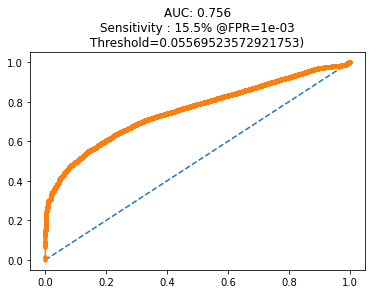

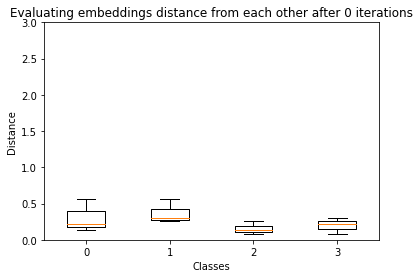

In [0]:
#Testing on an untrained network
probs,yprob = compute_probs(network,x_test_origin[:500,:,:,:],y_test_origin[:500])
fpr, tpr, thresholds,auc = compute_metrics(probs,yprob)
draw_roc(fpr, tpr,thresholds)
draw_interdist(network,n_iteration)

In [0]:
def DrawTestImage(network, images, refidx=0):
    '''
    Evaluate some pictures vs some samples in the test set
        image must be of shape(1,w,h,c)
    
    Returns
        scores : resultat des scores de similarités avec les images de base => (N)
    
    '''
    N=4
    _, w,h,c = dataset_test[0].shape
    nbimages=images.shape[0]
    
    #generates embedings for given images
    image_embedings = network.predict(images)
    
    #generates embedings for reference images
    ref_images = np.zeros((nb_classes,w,h,c))
    for i in range(nb_classes):
        ref_images[i,:,:,:] = dataset_test[i][refidx,:,:,:]
    ref_embedings = network.predict(ref_images)
            
    for i in range(nbimages):
        #Prepare the figure
        fig=plt.figure(figsize=(16,2))
        subplot = fig.add_subplot(1,nb_classes+1,1)
        axis("off")
        plotidx = 2
            
        #Draw this image    
        plt.imshow(images[i,:,:,],vmin=0, vmax=1)
        subplot.title.set_text("Test image")
            
        for ref in range(nb_classes):
            #Compute distance between this images and references
            dist = compute_dist(image_embedings[i,:],ref_embedings[ref,:])
            #Draw
            subplot = fig.add_subplot(1,nb_classes+1,plotidx)
            axis("off")
            plt.imshow(ref_images[ref,:,:,],vmin=0, vmax=1)
            subplot.title.set_text(("Class {0}\n{1:.3e}".format(ref,dist)))
            plotidx += 1

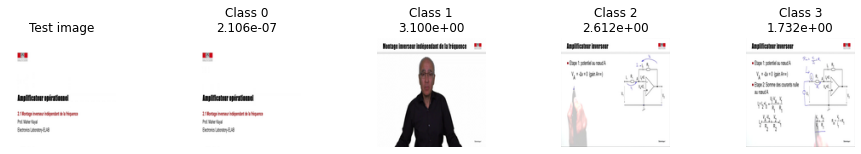

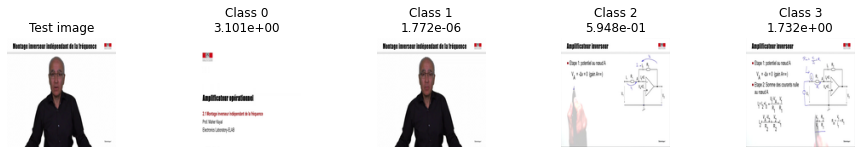

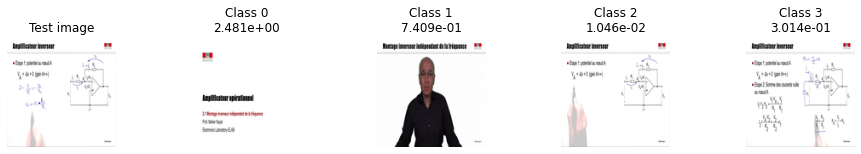

In [0]:
for i in range(3):
    DrawTestImage(network,np.expand_dims(dataset_train[i][0,:,:,:],axis=0))

In [0]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
dummy_target = [np.zeros((batch_size,15)) for i in range(3)]
for i in range(1, n_iter+1):
    triplets = get_batch_hard(200,16,16,network)
    loss = network_train.train_on_batch(triplets, None)
    n_iteration += 1
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("[{3}] Time for {0} iterations: {1:.1f} mins, Train Loss: {2}".format(i, (time.time()-t_start)/60.0,loss,n_iteration))
        probs,yprob = compute_probs(network,x_test_origin[:n_val,:,:,:],y_test_origin[:n_val])
        #fpr, tpr, thresholds,auc = compute_metrics(probs,yprob)
        #draw_roc(fpr, tpr)

Starting training process!
-------------------------------------

 ------------- 

[1000] Time for 1000 iterations: 26.4 mins, Train Loss: 1.9366645812988281

 ------------- 

[2000] Time for 2000 iterations: 52.6 mins, Train Loss: 1.1471049785614014


In [0]:
#Plotting AUC Curve and BoxPlot for Evaluation of results
probs,yprob = compute_probs(network,x_test_origin,y_test_origin)
fpr, tpr, thresholds,auc = compute_metrics(probs,yprob)
#Function to plot ROC
draw_roc(fpr, tpr,thresholds)
#Function to Plot BoxPlot
draw_interdist(network,n_iteration)

In [0]:
#Saving the JSON File and Weights into H5 File
# serialize model to JSON
model_json = network_train.to_json()
with open("siamese_change_detection_new.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
network_train.save_weights("siamese_change_detection_new.h5")
print("Saved model to disk")

Saved model to disk
